# Churn Analysis Modeling & Evaluation
Code & Logic


#### This file starts with a Pandas DataFrame that was generated by `account_metadata.ipynb`

Consider the following hypothesis:

---
> $H_1$: It is possible to predict (with some metric) if an account will be closed within the next 30-days using at minimum the following feature set:

>> {
    previous 30-transactions,
    is joint account?,
    age of account owner
}
---
### FINAL STEP: Feature Set Modelling & Model Evaluation
> When considering $H_1$ or $H_0$, how do we model our churn analysis given our feature set?

For the aforementioned hypothesis:
This Jupyter Notebook is concerned with modeling  where additional separate files exist for prior steps.

* While our lookback period for **closed/open acounts** is **1/1/2022 - 8/1/2022** when we examine **metadata** associated with these accounts (but not account transactions) this examination period will consist of **9/1/2021 - 8/1/2022**.
    - 9/1/2022 has been chosen as a start date as it represents 90-days prior
    - 8/1/2022 has been chosen as an end date as it coincides with the account closure/opening end constraint
* For our features below we will not present data collected on closed accounts for the 30-days immediately prior to an account closure.
    - this prevents us from creating a model which uses future data.


#### IMPORTANT NOTE: Exploration carried out via BELLCO_PROD_DNA.OSIBANK, Bellco Credit Union's institutional data.

In [1]:
import numpy as np
import pandas as pd
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import col, lit, sum as sum_, min as min_, max as max_, count as count_
import snowflake.snowpark.functions as f
import yaml
import os
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Load Pandas DataFrame

In [2]:
df = pd.read_pickle('churn_final_pandas_dataframe')
df

,trxn_acct,retire_acct,stmnt_acct,acct_open,num_acct_roles,acct_age_days,nsf_fees,uncollected_funds,atm_withdr,past_due,avg_acct_bal,acctlockoutflag,acct_type,acct_solo,acct_own_age,own_valid,visa_holder,credit_cat,zipcode,num_trxn,rtxn_source_mode,trxn_issues
0,0,0,0,1,2,962,0,0,0,0,1376.174442,0,Externally Serviced,1,33,0,0,bad,80026,32,Batch,0
1,0,0,0,1,2,1251,0,0,0,0,1376.174442,0,Externally Serviced,1,44,0,0,bad,80134,32,Batch,0
2,0,0,0,1,2,1604,0,0,0,0,1376.174442,0,Externally Serviced,1,28,0,0,poor,80012,35,Batch,0
3,0,0,0,1,2,222,0,0,0,0,1376.174442,0,Externally Serviced,1,49,0,0,fair,80138,40,Batch,0
4,0,0,0,1,2,5075,0,0,0,0,1376.174442,0,Externally Serviced,1,71,0,0,good,80221,122,Batch,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115995,1,0,1,1,1,721,1,0,0,0,648.99339207048,0,Checking,0,30,1,0,poor,80260,706,ATM,0
115996,1,0,1,1,3,1161,0,0,1,0,4937.65914854027,0,Checking,0,57,1,0,bad,80233,1462,ATM,1
115997,1,0,1,1,3,324,0,0,1,0,179.04038327526,0,Checking,0,19,1,0,bad,80227,995,ATM,0
115998,1,0,1,1,3,6558,1,0,1,0,416.12481573451,0,Checking,0,51,1,0,bad,80602,1279,ATM,1


In [3]:
df['acctlockoutflag'].value_counts(dropna=True)

0    112362
1      3638
Name: acctlockoutflag, dtype: int64

# Examine Features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116000 entries, 0 to 115999
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   trxn_acct          116000 non-null  int64   
 1   retire_acct        116000 non-null  int64   
 2   stmnt_acct         116000 non-null  int64   
 3   acct_open          116000 non-null  int8    
 4   num_acct_roles     116000 non-null  int32   
 5   acct_age_days      116000 non-null  int32   
 6   nsf_fees           116000 non-null  int32   
 7   uncollected_funds  116000 non-null  int32   
 8   atm_withdr         116000 non-null  int32   
 9   past_due           116000 non-null  int32   
 10  avg_acct_bal       116000 non-null  object  
 11  acctlockoutflag    116000 non-null  int32   
 12  acct_type          116000 non-null  object  
 13  acct_solo          116000 non-null  int64   
 14  acct_own_age       116000 non-null  int32   
 15  own_valid          116000 non-null

# Features
For a listing and explanation of our features see `account_metadata.ipynb`

### Binary
* `trxn_acct`
* `retire_acct`
* `stmnt_acct`
* `nsf_fees`
* `uncollected_funds`
* `atm_withdr`
* `past_due`
* `acctlockoutflag`
* `acct_solo`
* `own_valid`
* `trxn_issues`
* `acct_open` - dependent variable

### Continuous
* `num_acct_roles`
* `acct_age_days`
* `avg_acct_bal`
* `acct_own_age`
* `num_trxn`

### Categorical
* `acct_type`
* `credit_cat`
* `zipcode`
* `rtxn_source_mode`

In [5]:
y = df['acct_open']
df.drop('acct_open', axis=1, inplace=True)
X = df.copy()

display(X)
display(y)

,trxn_acct,retire_acct,stmnt_acct,num_acct_roles,acct_age_days,nsf_fees,uncollected_funds,atm_withdr,past_due,avg_acct_bal,acctlockoutflag,acct_type,acct_solo,acct_own_age,own_valid,visa_holder,credit_cat,zipcode,num_trxn,rtxn_source_mode,trxn_issues
0,0,0,0,2,962,0,0,0,0,1376.174442,0,Externally Serviced,1,33,0,0,bad,80026,32,Batch,0
1,0,0,0,2,1251,0,0,0,0,1376.174442,0,Externally Serviced,1,44,0,0,bad,80134,32,Batch,0
2,0,0,0,2,1604,0,0,0,0,1376.174442,0,Externally Serviced,1,28,0,0,poor,80012,35,Batch,0
3,0,0,0,2,222,0,0,0,0,1376.174442,0,Externally Serviced,1,49,0,0,fair,80138,40,Batch,0
4,0,0,0,2,5075,0,0,0,0,1376.174442,0,Externally Serviced,1,71,0,0,good,80221,122,Batch,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115995,1,0,1,1,721,1,0,0,0,648.99339207048,0,Checking,0,30,1,0,poor,80260,706,ATM,0
115996,1,0,1,3,1161,0,0,1,0,4937.65914854027,0,Checking,0,57,1,0,bad,80233,1462,ATM,1
115997,1,0,1,3,324,0,0,1,0,179.04038327526,0,Checking,0,19,1,0,bad,80227,995,ATM,0
115998,1,0,1,3,6558,1,0,1,0,416.12481573451,0,Checking,0,51,1,0,bad,80602,1279,ATM,1


0         1
1         1
2         1
3         1
4         1
         ..
115995    1
115996    1
115997    1
115998    1
115999    1
Name: acct_open, Length: 116000, dtype: int8

## Examine Covariance
https://seaborn.pydata.org/examples/many_pairwise_correlations.html

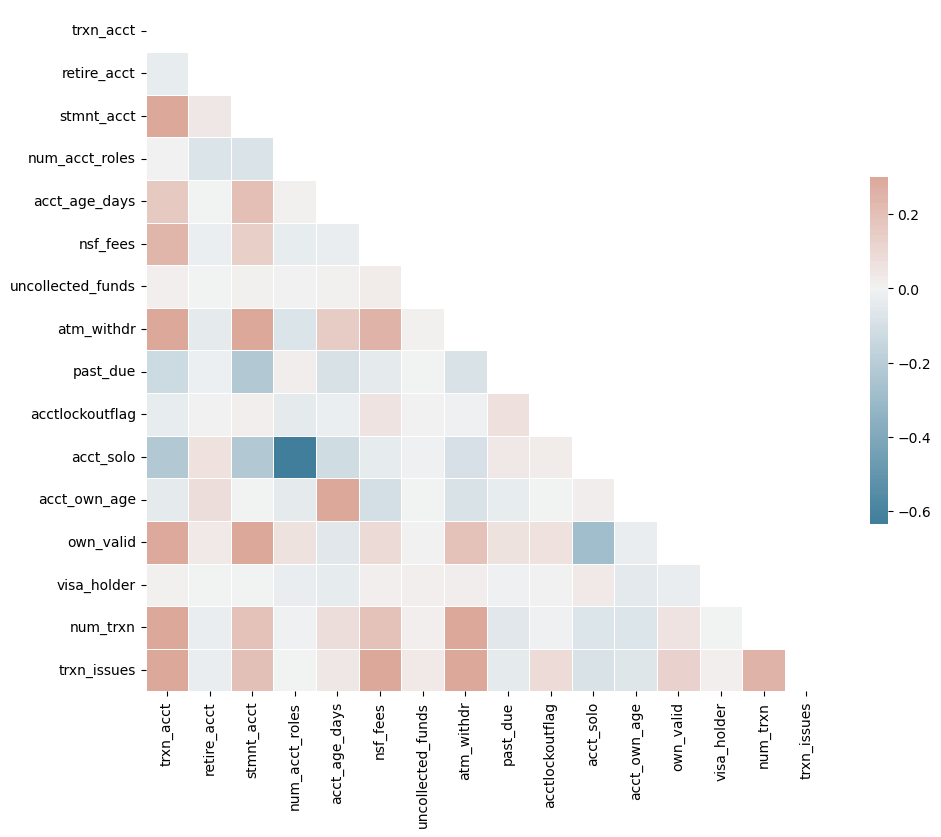

In [6]:
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

* We find a relationship between the number of account roles and if the account is solely owned. Therefore we will drop `num_acct_roles` to avoid confounding the analysis.
* For a similar reason we will drop `stmnt_acct` & `trxn_acct` as most transactional accounts will have statements generated and we also capture the type of account, more broadly, via `acct_typ` where we can infer that for example checking accounts are transactional accounts which likely receive statements.

In [7]:
X.drop(['num_acct_roles', 'stmnt_acct', 'trxn_acct'], axis=1, inplace=True)

# Prep Data for Modeling

## One-Hot Encode Categorical Variables

In [8]:
from sklearn.preprocessing import OneHotEncoder


X_cat = X[['acct_type', 'credit_cat', 'rtxn_source_mode', 'zipcode']]

ohe = OneHotEncoder()
# ohe = OneHotEncoder(drop='first')

ohe.fit(X_cat)
encoded_features = ohe.transform(X_cat)
print(ohe.get_feature_names_out())

['acct_type_Checking' 'acct_type_Commercial Loan'
 'acct_type_Consumer Loan' ... 'zipcode_99709' 'zipcode_99741'
 'zipcode_99901']


In [9]:
# Convert encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out(X_cat.columns))

In [10]:
# Concatenate encoded DataFrame with the original DataFrame
X_prcs = pd.concat([encoded_df, X.drop(columns=X_cat)], axis=1)
X_prcs

acct_type_Checking  acct_type_Commercial Loan  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   
...                    ...                        ...   
115995                 1.0                        0.0   
115996                 1.0                        0.0   
115997                 1.0                        0.0   
115998                 1.0                        0.0   
115999                 1.0                        0.0   

        acct_type_Consumer Loan  acct_type_Externally Serviced  \
0                           0.0                            1.0   
1                           0.0                            1.0   
2                           0.0                            1.0   
3                           0.0                            1.0   
4                           0.0                            1.0   
...                         ...                            ...   
115995                      0.0                            0.0   
115996                      0.0                            0.0   
115997                      0.0                            0.0   
115998                      0.0                            0.0   
115999                      0.0                            0.0   

        acct_type_General Ledger  acct_type_Master Line  \
0                            0.0                    0.0   
1                            0.0                    0.0   
2                            0.0                    0.0   
3                            0.0                    0.0   
4                            0.0                    0.0   
...                          ...                    ...   
115995                       0.0                    0.0   
115996                       0.0                    0.0   
115997                       0.0                    0.0   
115998                       0.0                    0.0   
115999                       0.0                    0.0   

        acct_type_Mortgage Loan  acct_type_Official Check Accounts  \
0                           0.0                                0.0   
1                           0.0                                0.0   
2                           0.0                                0.0   
3                           0.0                                0.0   
4                           0.0                                0.0   
...                         ...                                ...   
115995                      0.0                                0.0   
115996                      0.0                                0.0   
115997                      0.0                                0.0   
115998                      0.0                                0.0   
115999                      0.0                                0.0   

        acct_type_Regulatory Reporting  acct_type_Retirement Account  \
0                                  0.0                           0.0   
1                                  0.0                           0.0   
2                                  0.0                           0.0   
3                                  0.0                           0.0   
4                                  0.0                           0.0   
...                                ...                           ...   
115995                             0.0                           0.0   
115996                             0.0                           0.0   
115997                             0.0                           0.0   
115998                             0.0                           0.0   
115999                             0.0                           0.0   

        acct_type_Savings  acct_type_Time Deposit  credit_cat_bad  \
0                     0.0                     

## Train-Test Split 
70 **:** 30 ratio (train : test)

In [11]:
from sklearn.model_selection import train_test_split


# we make sure to pass the parameter stratify so that we get equal representation for `acct_open`: 0 or 1
X_train, X_test, y_train, y_test = train_test_split(X_prcs, y, test_size=(3/10), random_state=42, stratify=y) 

# Classification Model: RandomForest 
RandomForest is an ensemble method comprised of numerous decision trees and known for its versatility.

In [12]:
from sklearn.ensemble import RandomForestClassifier


rf_class = RandomForestClassifier(   # default criterion is 'gini' impurity
    n_estimators=100, 
    max_features='sqrt',
    max_depth=10,
    n_jobs=-1,                       # -1 for all CPUs
    random_state=42,                 # 42 is the answer to life, the universe, and everything
#     warm_start=True
)   

start = time()
rf_class.fit(X_train, y_train)
y_test_pred = rf_class.predict(X_test)
stop = time()
print(f"{(stop - start) / 60:.3} min execution time")

3.92 min execution time


### Feature Importance via RandomForestClassifier algorithm

In [13]:
from collections import OrderedDict


# Get feature importances
feature_importances = rf_class.feature_importances_

# Map feature importances to feature names
feature_names = X_prcs.columns
importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}
importance_dict

d_descending = OrderedDict(
    sorted(importance_dict.items(), key=lambda kv: kv[1], reverse=True)
)

pd.DataFrame(d_descending.items(), columns=['feature', 'importance']).head(35)

,feature,importance
0,acct_type_Consumer Loan,0.138581
1,num_trxn,0.132793
2,atm_withdr,0.087311
3,acct_type_Checking,0.084713
4,rtxn_source_mode_ATM,0.072418
5,avg_acct_bal,0.070454
6,nsf_fees,0.064982
7,rtxn_source_mode_Batch,0.052216
8,acct_age_days,0.043322
9,acct_type_Time Deposit,0.036135


# Model Evaluation

### Confusion Matrix
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

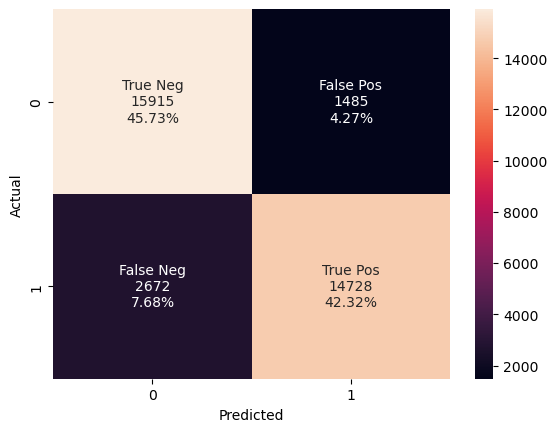

In [14]:
from sklearn.metrics import confusion_matrix


cf_matrix = confusion_matrix(y_test, y_test_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='');
plt.xlabel('Predicted');
plt.ylabel('Actual');

### Classification Report

In [15]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     17400
           1       0.91      0.85      0.88     17400

    accuracy                           0.88     34800
   macro avg       0.88      0.88      0.88     34800
weighted avg       0.88      0.88      0.88     34800



* **Precision** - measures the proportion of correctly predicted positive instances among all instances predicted as positive in a classification task.
* **Recall** - also known as sensitivity, calculates the proportion of correctly predicted positive instances among all actual positive instances in a classification task.
* **F1-Score** - the harmonic mean of precision and recall, providing a balanced measure to assess a model's performance in binary classification tasks.
* **Support** - refers to the number of actual occurrences of a class in the dataset and is used to calculate various metrics in classification evaluations.
* **Accuracy** - quantifies the ratio of correctly predicted instances to the total number of instances in a classification task, offering a general overview of a model's overall correctness.

### ROC Curve

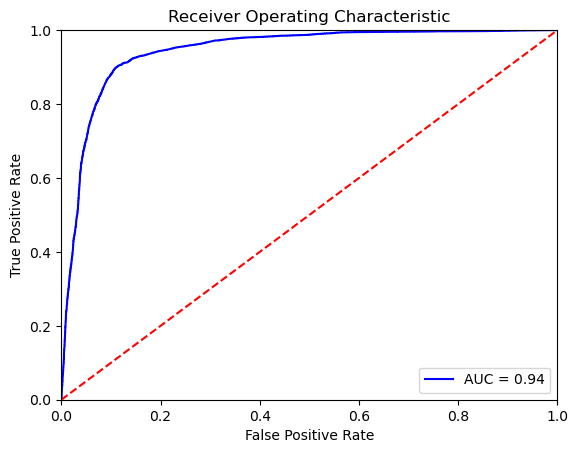

In [16]:
import sklearn.metrics as metrics


probs = rf_class.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

The Random Forest classifier machine learning model has achieved notable success, demonstrating strong predictive capabilities. This achievement is supported by key performance metrics, including precision, recall, and the F1-Score, which yielded favorable results for both classifications: closed and open (or active) accounts. For closed accounts, the precision, recall, and F1-Score were 0.86, 0.91, and 0.88 respectively, while for open accounts, the values were 0.91, 0.85, and 0.88. Moreover, the model's overall accuracy stands at an impressive 88%. We find precision and recall are balanced. Additionally, the Receiver Operating Characteristic (ROC) analysis, with an area under the curve of 0.94 out of a possible 1.0, further underscores the robustness of this model for churn analysis. 

Given the RandomForest algorithm's inherent ability to furnish features along with their corresponding significance, we have derived outcomes pertaining to the foremost features. Our analysis reveals that within the purview of our model, account classifications such as consumer loan and checking account hold significant prominence. Additionally, the count of transactions and the occurrence of ATM withdrawals emerge as pivotal factors in our model's capacity to predict the likelihood of an account closing or remaining open.

## Additional Points of Exploration
* Cross-validation
* Additional classification models (XGBoost, LogisticRegression, etc.)
* Grid search for determining model hyperparameters of the optimum model